In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!pip install pyvis
!pip install gensim==4.1.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# import bibtexparser
import pandas as pd
import spacy
import re

from tqdm.auto import tqdm
from gensim.corpora import Dictionary
from gensim.models import LdaModel
import requests
import matplotlib.pyplot as plt

from io import BytesIO
from PIL import Image
from wordcloud import WordCloud
from nltk.probability import FreqDist

In [ ]:
from gensim.models import CoherenceModel
import plotly.graph_objects as go
import plotly.io as pio
import gensim
# import pyLDAvis
# import pyLDAvis.gensim_models as gensimvis
import datetime 
from plotly.offline import init_notebook_mode, iplot, plot
import pickle
pio.renderers.default = "notebook_connected"
init_notebook_mode(connected=True)

In [ ]:
import networkx as nx
from pyvis.network import Network
from IPython.core.pylabtools import figsize


In [ ]:
!pip install octis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from octis.evaluation_metrics.diversity_metrics import TopicDiversity
from octis.evaluation_metrics.coherence_metrics import Coherence
from octis.dataset.dataset import Dataset
import numpy as np


In [ ]:
df = pd.read_csv('/content/gdrive/MyDrive/thesis_datasets/emotion_regulation/emotion_regulation.csv')

# PRE-PROCESSING

In [ ]:
def removing_na(df, COLUMN):
  # remove the rows with NA
  df = df.loc[(df[COLUMN].isna() == False)]
  return df

In [ ]:
def preprocessing(df, COLUMN):
  # pre processing
  nlp = spacy.load("en_core_web_sm")
  texts = df[COLUMN]

  processed_texts = [text for text in tqdm(nlp.pipe(texts, 
                                              disable=["ner",
                                                       "parser"]),
                                          total=len(texts))]
  # lemmatizing, removing stop words and panctuation, lowercasing and taking nouns and adjectives
  lemmatized_texts = [[token.lemma_.lower() for token in doc if 
                    not token.is_punct and not token.is_stop and (token.pos_ == 'NOUN' or token.pos_ == 'ADJ')] for doc in processed_texts]
  # remove numbers
  lemmatized_texts = [[re.sub(r'^[0-9]+|^.$', '', word) for word in text] for text in lemmatized_texts]
  # remove empty values
  lemmatized_texts = [[token for token in text if token != ''] for text in lemmatized_texts]
  return lemmatized_texts

In [ ]:
df_keywords  = removing_na(df, COLUMN = 'keywords')
lemmatized_keywords = preprocessing(df_keywords, COLUMN = 'keywords')

  0%|          | 0/5031 [00:00<?, ?it/s]

In [ ]:
df_abstracts  = removing_na(df, COLUMN = 'abstract')
lemmatized_abstracts = preprocessing(df_abstracts, COLUMN = 'abstract')

  0%|          | 0/6098 [00:00<?, ?it/s]

# EXPLORATORY ANALYSIS

In [ ]:
allkeywords = []
for wordlist in lemmatized_keywords:
    allkeywords += wordlist

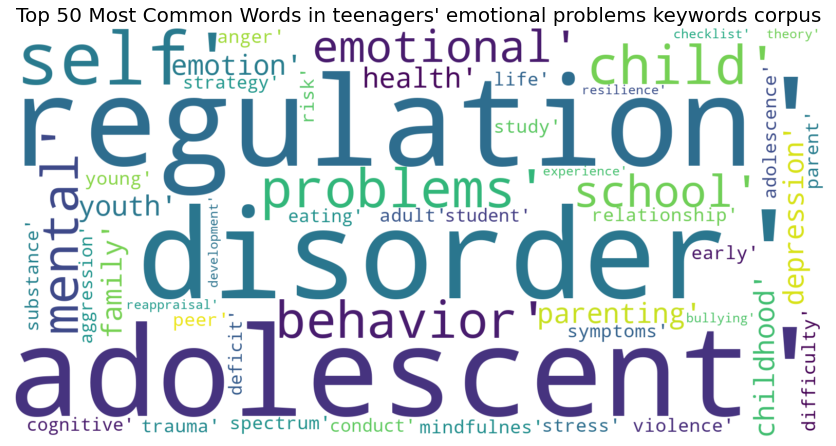

In [ ]:
mostcommon = FreqDist(allkeywords).most_common(50)
wordcloud = WordCloud(width=1600, height=800, background_color='white').generate(str(mostcommon))
fig = plt.figure(figsize=(18,6), facecolor='white')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Top 50 Most Common Words in teenagers\' emotional problems keywords corpus', fontsize=20)
plt.tight_layout(pad=0)
plt.show()

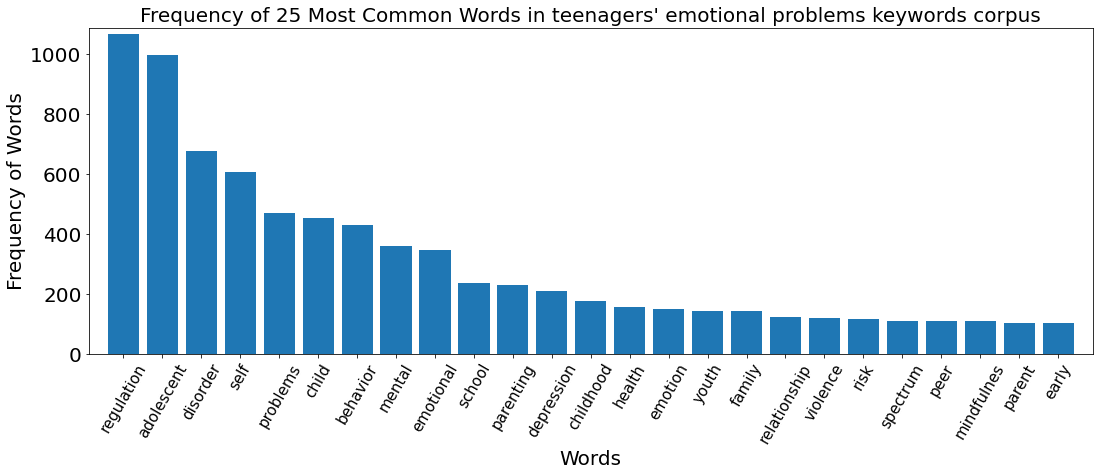

In [ ]:
mostcommon_small = FreqDist(allkeywords).most_common(25)
x, y = zip(*mostcommon_small)
plt.figure(figsize=(18,6))
plt.margins(0.02)
plt.bar(x, y)
plt.xlabel('Words', fontsize=20)
plt.ylabel('Frequency of Words', fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(rotation=60, fontsize=15)
plt.title('Frequency of 25 Most Common Words in teenagers\' emotional problems keywords corpus', fontsize=20)
plt.show()

In [ ]:
allabstracts = []
for wordlist in lemmatized_abstracts:
    allabstracts += wordlist

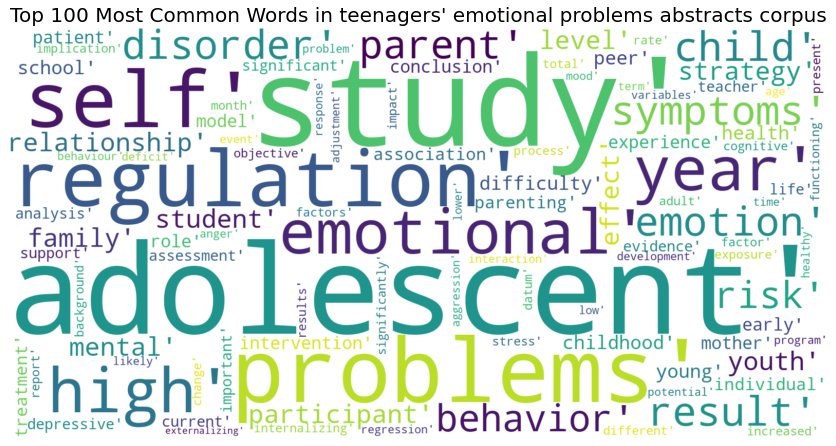

In [ ]:
mostcommon = FreqDist(allabstracts).most_common(100)
wordcloud = WordCloud(width=1600, height=800, background_color='white').generate(str(mostcommon))
fig = plt.figure(figsize=(18,6), facecolor='white')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Top 100 Most Common Words in teenagers\' emotional problems abstracts corpus', fontsize=20)
plt.tight_layout(pad=0)
plt.show()

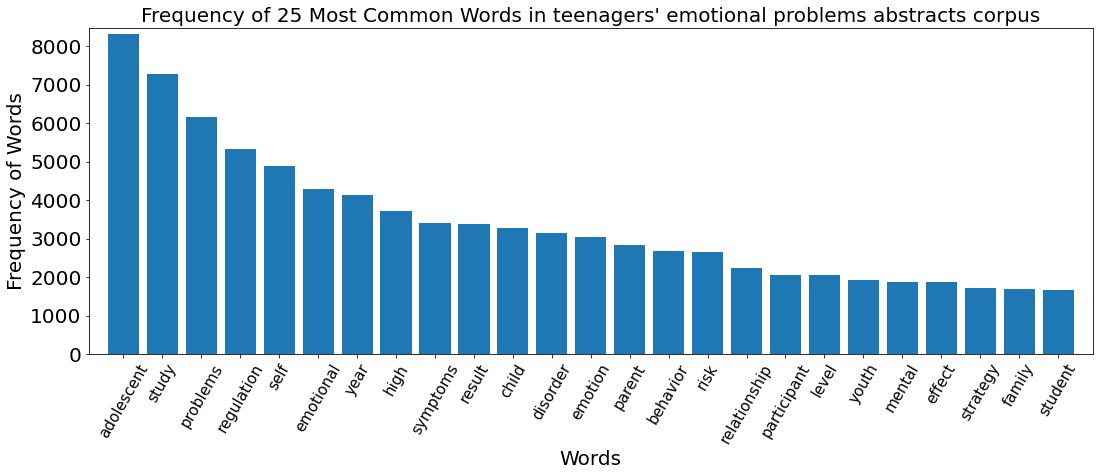

In [ ]:
mostcommon_small = FreqDist(allabstracts).most_common(25)
x, y = zip(*mostcommon_small)
plt.figure(figsize=(18,6))
plt.margins(0.02)
plt.bar(x, y)
plt.xlabel('Words', fontsize=20)
plt.ylabel('Frequency of Words', fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(rotation=60, fontsize=15)
plt.title('Frequency of 25 Most Common Words in teenagers\' emotional problems abstracts corpus', fontsize=20)
plt.show()

In [ ]:
MIN_DF = 5 # setting minimum document frequency -> we keep words which occur at least in 5 documents
MAX_DF = 0.85 # maximum document frequency -> word has to be included in less than 85 percent of document in order to be included

def get_dict_and_corpus(lemmatized_texts, MIN_DF, MAX_DF):
  dictionary = Dictionary(lemmatized_texts) # get the vocabulary
  dictionary.filter_extremes(no_below=MIN_DF, 
                            no_above=MAX_DF) #filtering out of the extreme values 
  corpus = [dictionary.doc2bow(text) for text in lemmatized_texts] #creating corpus
  return dictionary,corpus

In [ ]:
keywords_dict, corpus_keywords = get_dict_and_corpus(lemmatized_keywords, MIN_DF, MAX_DF)
abstracts_dict, corpus_abstracts = get_dict_and_corpus(lemmatized_abstracts, MIN_DF, MAX_DF)

In [ ]:
print('Number of unique tokens in keywords: %d' % len(keywords_dict))
print('Number of documents in keywords: %d' % len(corpus_keywords)) 

Number of unique tokens in keywords: 436
Number of documents in keywords: 5031


In [ ]:
print('Number of unique tokens in abstracts: %d' % len(abstracts_dict))
print('Number of documents in abstracts: %d' % len(corpus_abstracts)) 

Number of unique tokens in abstracts: 3018
Number of documents in abstracts: 6098


## functions for LDA and topic coherence

In [ ]:
def get_lda(n_topics, corpus, dictionary):
    """
    Returns the lda model.
    """
    N_TOPICS = n_topics # set number of topics
    N_ITERATIONS = 1000 # parameter to set number of iterations

    lda = LdaModel(corpus,id2word=dictionary, num_topics=N_TOPICS, iterations = 1000, random_state = 28) #train the model
    return lda #return the model

In [ ]:
def analyse_topics(N_TOPICS, lda):
    """
    Prints topics

    Parameters
    ----------
    N_TOPICS : int
        number of topics to be found
    lda : instance of LdaMallet
        trained model
        
    Returns
    -------
    """
    for topic in range(N_TOPICS): #for loop to go over all topics
        words = lda.show_topic(topic, 10) #get the words
        topic_n_words = ' '.join([word[0] for word in words]) 
        print('Topic {}: {}'.format(str(topic), topic_n_words)) #printing the topic

In [ ]:
def get_coherence(lda, tokenized_text, dictionary):
    """
    Returns the coherence number of the model.
    Resource: https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0

    Parameters
    ----------
    lda : int
        number of topics to be found
    tokenized_text : list
        list of lists of tokenized text
    dictionary : Dictionary
        dictionary of tokenized text
    
    Returns
    -------
    int
        coherence value
    """ 
    coherence_model = CoherenceModel(model=lda, texts=tokenized_text, dictionary=dictionary, coherence='c_v') #get coherence model with type of c_v coherence
    return coherence_model.get_coherence() #get coherence and return it 

In [ ]:
def create_dict_top2word(N_TOPICS, lda):
  topic2words = {}
  output = []
  for topic in range(N_TOPICS): #for loop to go over all topics
    words = lda.show_topic(topic, 20) #get the words
    topic2words[topic] = [word[0] for word in words[:10]]
    output.append([word[0] for word in words[:10]])

  output_dict = {"topics": output}
  return topic2words, output_dict


In [ ]:
def get_diversity(N_TOPICS, lda):
  _, output_dict = create_dict_top2word(N_TOPICS, lda)
  topic_diversity= TopicDiversity(topk=10)

  return topic_diversity.score(output_dict)

In [ ]:
MIN_N_TOPICS = 10
MAX_N_TOPICS = 150

def get_topics_and_score(corpus, dictionary, lemmatized_texts):
  score = [] #list to store the score
  labels = [] #list to store the label
  models = [] #lsit to store the model
  diversity = []
  for k in tqdm(range(MIN_N_TOPICS,MAX_N_TOPICS)): 
      lda = get_lda(k, corpus, dictionary) #train the model
      score.append(get_coherence(lda, lemmatized_texts, dictionary)) #add coherence score to the list
      diversity.append(get_diversity(k,lda))
      labels.append(str(k)) #add number of topics to the list
      models.append(lda)#add model to the list

  return score, labels, models, diversity

In [ ]:
def visualize_metric(score, diversity, labels, text):
    """
    Returns the figure where coherence and diversity across different number of topics is visualised.

    Parameters
    ----------
    score : list
        list of int scores to be on y axis
    labels : list
        list of strings with labels to be on x axis
    
    Returns
    -------
     figure
    """


    plt.rcParams.update({'figure.figsize':(20,6), 'figure.dpi':70, 'font.size': 10})
    plt.scatter(labels, score, label=f'Topic Coherence')
    plt.scatter(labels, diversity, label=f'Topic Diversity')
    plt.xticks(np.arange(MIN_N_TOPICS, MAX_N_TOPICS, step=5))

    plt.title(f'Coherence and diversity scores plot {text}' )
    plt.xlabel("Topic")
    plt.ylabel('Score') 
    plt.legend()
    plt.show()

    return plt #return plt

## run the models and print the topic

In [ ]:
score_keywords, labels_keywords, models_keywords, diversity_keywords = get_topics_and_score(corpus_keywords, keywords_dict, lemmatized_keywords)

  0%|          | 0/140 [00:00<?, ?it/s]

In [ ]:
score_abstracts, labels_abstracts, models_abstracts, diversity_abstracts = get_topics_and_score(corpus_abstracts, abstracts_dict, lemmatized_abstracts)

  0%|          | 0/140 [00:00<?, ?it/s]

## visualise coherence

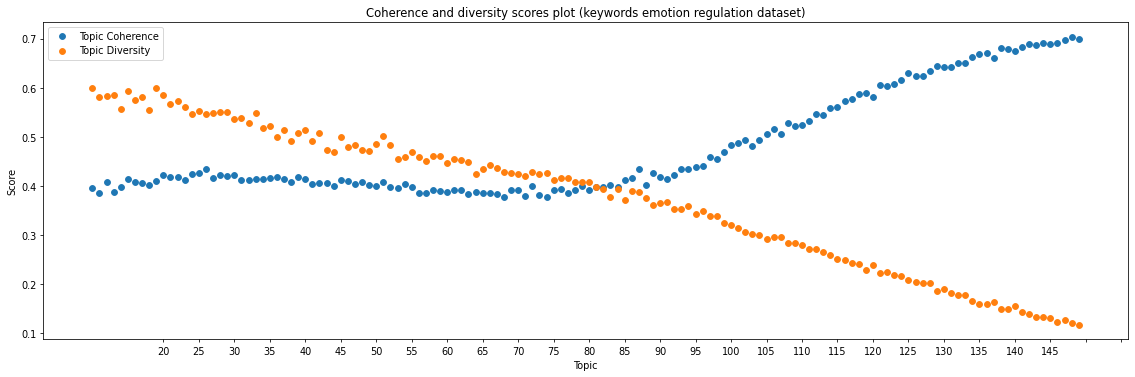

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

In [ ]:
visualize_metric(score_keywords, diversity_keywords, labels_keywords, '(keywords emotion regulation dataset)')

In [ ]:
# plot(visualize_metric(score_keywords, labels_keywords, diversity_keywords), filename = 'keywords_coherence_diversity_emotions.html') #visualising coherence

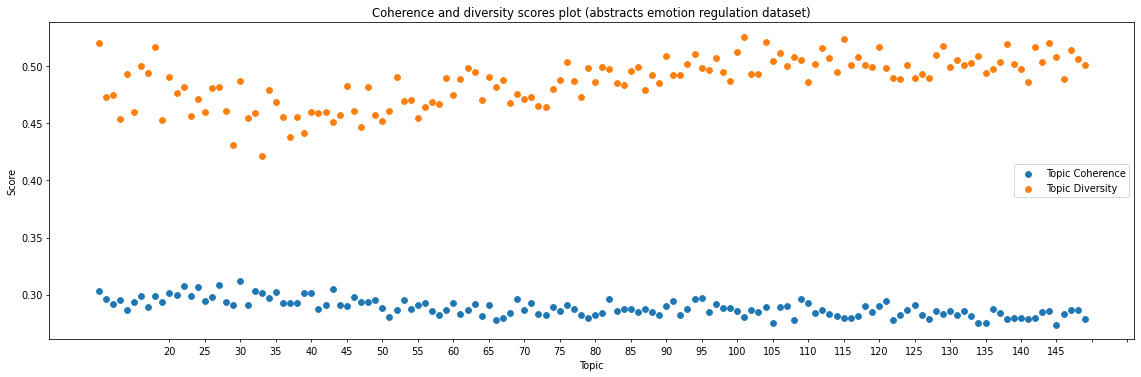

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

In [ ]:
visualize_metric(score_abstracts, diversity_abstracts, labels_abstracts, '(abstracts emotion regulation dataset)')


In [ ]:
# plot(visualize_metric(score_abstracts, labels_abstracts, diversity_abstracts), filename = 'abstracts_coherence_diversity_emotions.html') #visualising coherence


## functions for network

In [ ]:
# create df with nodes and edges
def generate_edges(topic2words):
  word2topics = {}
  for key ,values in topic2words.items():
    for value in values:
      if value in word2topics:
        word2topics[value].append(key)
      else:
        word2topics[value] = [key]

  source = []
  target = []
  for topic, words in topic2words.items():
    for word in words:
      for top in word2topics[word]:
        if top != topic:
          source.append(f"{words[0]}\n{words[1]}")
          target_words = topic2words[top]
          target.append(f"{target_words[0]}\n{target_words[1]}")


  df = pd.DataFrame()
  df['source'] = source
  df['target'] = target
  df['weight'] = 1

  return df

In [ ]:
def df2network(edges_df):
  network = nx.from_pandas_edgelist(edges_df, source = 'source', target = 'target', edge_attr = 'weight',create_using=nx.MultiGraph())
  return network

## topic coherence, topic diversity and network for keywords

In [ ]:
topic_quality_keywords = np.multiply(score_keywords, diversity_keywords)


In [ ]:
max_topic_keywords = max(topic_quality_keywords)
print(f'max topic quality for keywords: {max_topic_keywords}')

max_topic_index_key = np.argmax(topic_quality_keywords)
max_topic_key = max_topic_index_key + MIN_N_TOPICS
print(f'number of topics: {max_topic_key}')

max_key_model = models_keywords[max_topic_index_key]

max topic quality for keywords: 0.2471518923341152
number of topics: 20


In [ ]:
print(f'topic coherence keywords : {score_keywords[max_topic_index_key]}')
print(f'topic diversity keywords : {diversity_keywords[max_topic_index_key]}')

topic coherence keywords : 0.4224818672378038
topic diversity keywords : 0.585


In [ ]:
print("------Print the topics of the best model:")
analyse_topics(max_topic_key, max_key_model) #print the topics found
print("------")

------Print the topics of the best model:
Topic 0: early anger emotional school program use education adolescent children anxiety
Topic 1: young study mindfulnes regulation adulthood competence sinus adolescent self childhood
Topic 2: theory event self life regulation adolescent aggression anger informant non
Topic 3: adult stres self life conflict middle parent satisfaction young stress
Topic 4: problems adolescent emotional disorder behavior immigrant school mental sleep regulation
Topic 5: youth disorder child regulation deficit development cross emotional learning mood
Topic 6: disorder rate heart trauma mental adolescent sibling stress potential psychopathology
Topic 7: parenting adolescent family support service violence externalizing internalizing problems relationship
Topic 8: regulation adolescent strategy emotion cognitive parenting emotional self disorder behavior
Topic 9: disorder spectrum symptoms bullying stress violence victimization cyberbullying sexual behavior
Topic 1

In [ ]:
dict_keywords,_ = create_dict_top2word(max_topic_key, max_key_model)
keywords_edges = generate_edges(dict_keywords)
keywords_edges.to_csv("LDA_keywords_emotions_network.csv")

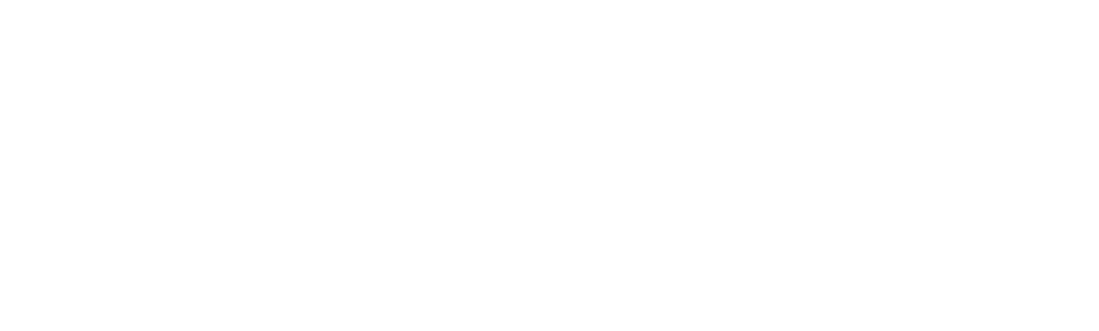

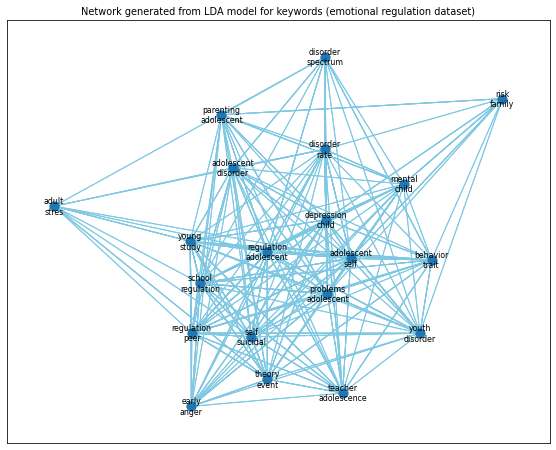

In [ ]:
#create plot 2D

limits = plt.axis("off")
fig, ax = plt.subplots(1, 1, figsize=(10,8))
ax.set_title('Network generated from LDA model for keywords (emotional regulation dataset)', 
             fontdict = {'fontsize': 10})
nx.draw_networkx(df2network(keywords_edges), node_size = 100, ax = ax, 
                 edge_color = '#7EC8E3',  linewidths = 0.4, font_size = 8)
                 

In [ ]:
#create interactive plot network
net = Network(notebook=True)

net.from_nx(df2network(keywords_edges))

net.show("LDA_net_keywords_emotions.html")

## topic coherence, topic diversity and network for abstracts




In [ ]:
topic_quality_abstracts = np.multiply(score_abstracts, diversity_abstracts)


In [ ]:
topic_quality_abstracts

array([0.15758125, 0.14018035, 0.13853734, 0.13407144, 0.14126731,
       0.13497807, 0.14962112, 0.14285152, 0.15423778, 0.13289543,
       0.14771344, 0.14262216, 0.14837527, 0.13648234, 0.1443966 ,
       0.13555107, 0.14318059, 0.14840405, 0.13518775, 0.12534098,
       0.15200371, 0.13229551, 0.13919514, 0.12700981, 0.14253939,
       0.14153329, 0.13346557, 0.12832153, 0.13337662, 0.13293857,
       0.13861781, 0.13200432, 0.13373192, 0.13761931, 0.13304522,
       0.13990601, 0.13754933, 0.13133949, 0.14127062, 0.13493032,
       0.1304457 , 0.12942277, 0.14050113, 0.1387383 , 0.13540749,
       0.13230568, 0.1357885 , 0.13372325, 0.13204712, 0.14032998,
       0.1390843 , 0.13848594, 0.14277321, 0.14465704, 0.13243227,
       0.14290713, 0.13410889, 0.13639125, 0.1329185 , 0.14097347,
       0.13496343, 0.13837496, 0.13168485, 0.13125354, 0.13879542,
       0.13939366, 0.14647561, 0.14000127, 0.13343262, 0.13967414,
       0.1371303 , 0.14169937, 0.14753076, 0.13856732, 0.13882

In [ ]:

max_topic_abstracts = max(topic_quality_abstracts)
print(f'max topic coherence for keywords {max_topic_abstracts}')

max_topic_index_abs = np.argmax(max_topic_abstracts)
max_topic_abs = max_topic_index_abs + MIN_N_TOPICS
print(f'number of topics for abs: {max_topic_abs}')

max_abs_model = models_abstracts[max_topic_index_abs]

max topic coherence for keywords 0.1575812534878577
number of topics for abs: 10


In [ ]:
print(f'topic coherence keywords : {score_abstracts[max_topic_index_abs]}')
print(f'topic diversity keywords : {diversity_abstracts[max_topic_index_abs]}')

topic coherence keywords : 0.303040872092034
topic diversity keywords : 0.52


In [ ]:
print("------Print the topics of the best model:")
analyse_topics(max_topic_abs, max_abs_model) #print the topics found
print("------")

------Print the topics of the best model:
Topic 0: student adolescent study self symptoms peer victimization relationship result competence
Topic 1: self adolescent disorder study high family autism factor parent result
Topic 2: problems emotional patient study high year adolescent child difficulty result
Topic 3: adolescent immigrant study regulation emotion relationship emotional affective disorder level
Topic 4: teacher rating infant problems behavior connectivity parent study year informant
Topic 5: problems adolescent disorder study behavior year result high self mental
Topic 6: adolescent problems self study risk behavior symptoms effect year event
Topic 7: family child violence representation exposure class asian parent study functioning
Topic 8: regulation emotion study disorder adolescent self participant emotional training strategy
Topic 9: stress regulation emotion study response high marijuana young reactivity childhood
------


In [ ]:
dict_abstracts,_ = create_dict_top2word(max_topic_abs, max_abs_model)

abstracts_edges = generate_edges(dict_abstracts)
abstracts_edges.to_csv("LDA_abstracts_emotions_network_df.csv")

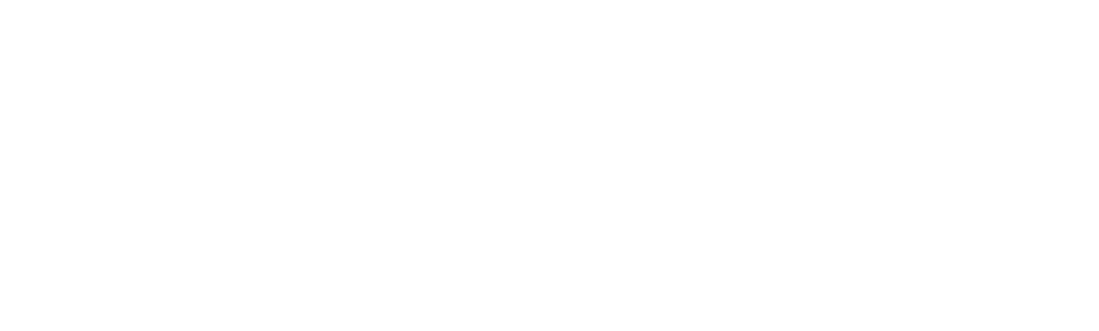

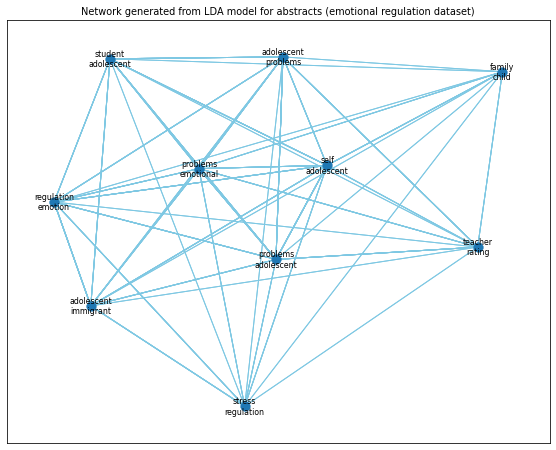

In [ ]:
# create plot 2D

limits = plt.axis("off")
fig, ax = plt.subplots(1, 1, figsize=(10,8))
ax.set_title('Network generated from LDA model for abstracts (emotional regulation dataset)', 
             fontdict = {'fontsize': 10})
nx.draw_networkx(df2network(abstracts_edges), node_size = 100, ax = ax, 
                 edge_color = '#7EC8E3',  linewidths = 0.4, font_size = 8)

In [ ]:
#create interactive plot network
net = Network(notebook=True)

net.from_nx(df2network(abstracts_edges))

net.show("LDA_net_abstracts_emotions_regulation.html")

In [ ]:
'123'

'123'